In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import torch.optim  as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy
import shap

from models.CNN_EEG import CNNEEG_32, restore_parameters, train_CNNEEG, evaluation_eegcnn
from utils import MakeDataset, generation_cnn_data, generation_cnn_noisedata, generation_cnn_con_data

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
eeg_col = ['EEG.Cz', 'EEG.Fz', 'EEG.Fp1',  'EEG.F7', 'EEG.F3', 'EEG.FC1', 'EEG.C3','EEG.FC5',
           'EEG.FT9', 'EEG.T7','EEG.CP5',  'EEG.CP1', 'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
           'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10', 'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4', 'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2']

In [4]:
path = './{}/base/{}.csv'
task = ['10','20','1back','3back']

# CYY base dataset train

In [5]:
cyj_cnn_eeg_input, cyj_cnn_output = generation_cnn_data(path, 'cyy', task, device)

10
20
1back
3back


In [6]:
print(cyj_cnn_eeg_input.size())
print(cyj_cnn_output.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [7]:
dataset = MakeDataset(cyj_cnn_eeg_input, cyj_cnn_output)
train_dataset, test_dataset = random_split(dataset, [1536,512])
trainloader = DataLoader(train_dataset, 
                         batch_size=256, 
                         shuffle=True)

testloader = DataLoader(test_dataset,
                        batch_size = 256,
                        shuffle=True)


In [8]:
model = CNNEEG_32(32)
his = train_CNNEEG(model, trainloader, 1000, 0.0001, device= device)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1 / 1000: Loss = 1.127
Epoch 2 / 1000: Loss = 1.095
Epoch 3 / 1000: Loss = 1.066
Epoch 4 / 1000: Loss = 1.041
Epoch 5 / 1000: Loss = 1.019
Epoch 6 / 1000: Loss = 0.997
Epoch 7 / 1000: Loss = 0.978
Epoch 8 / 1000: Loss = 0.965
Epoch 9 / 1000: Loss = 0.957
Epoch 10 / 1000: Loss = 0.951
Epoch 11 / 1000: Loss = 0.947
Epoch 12 / 1000: Loss = 0.944
Epoch 13 / 1000: Loss = 0.940
Epoch 14 / 1000: Loss = 0.937
Epoch 15 / 1000: Loss = 0.934
Epoch 16 / 1000: Loss = 0.931
Epoch 17 / 1000: Loss = 0.928
Epoch 18 / 1000: Loss = 0.925
Epoch 19 / 1000: Loss = 0.922
Epoch 20 / 1000: Loss = 0.919
Epoch 21 / 1000: Loss = 0.916
Epoch 22 / 1000: Loss = 0.913
Epoch 23 / 1000: Loss = 0.910
Epoch 24 / 1000: Loss = 0.908
Epoch 25 / 1000: Loss = 0.905
Epoch 26 / 1000: Loss = 0.903
Epoch 27 / 1000: Loss = 0.900
Epoch 28 / 1000: Loss = 0.898
Epoch 29 / 1000: Loss = 0.895
Epoch 30 / 1000: Loss = 0.893
Epoch 31 / 1000: Loss = 0.891
Epoch 32 / 1000: Loss = 0.888
Epoch 33 / 1000: Loss = 0.886
Epoch 34 / 1000: Lo

In [9]:
train_pred_list, train_target_list, test_pred_list, test_target_list = evaluation_eegcnn(model, trainloader, testloader, 256, device)

Train dataset loss : 0.7132128775119781
Train dataset acc :83.65885615348816%
Test dataset loss : 0.8618066012859344
Test dataset acc :68.5546875%


In [10]:
explainer_shap = shap.DeepExplainer(model, cyj_cnn_eeg_input.float()[:100])
shap_values = explainer_shap.shap_values(cyj_cnn_eeg_input.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [11]:
for i in range(len(shap_values)):
    shap_values[i] = shap_values[i].reshape(100, 120, 32)

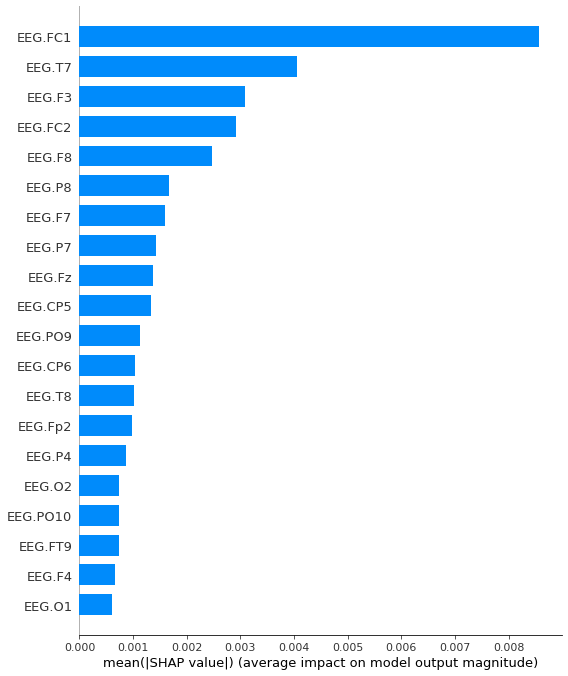

In [12]:
shap.summary_plot(shap_values[0][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

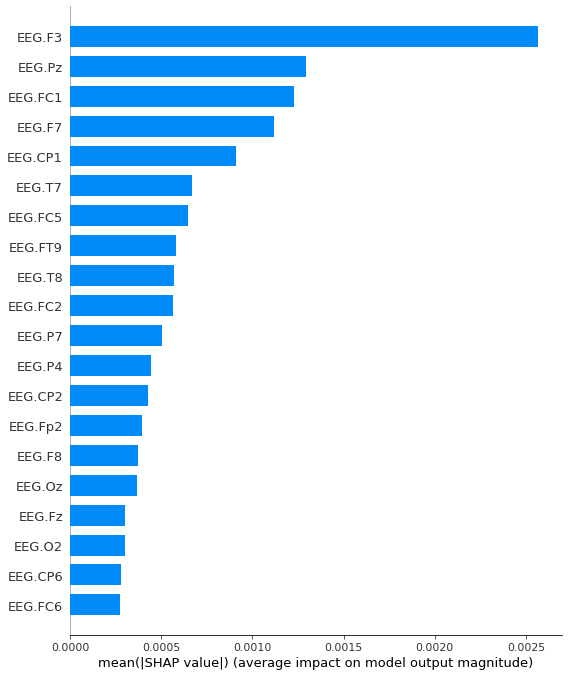

In [13]:
shap.summary_plot(shap_values[1][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

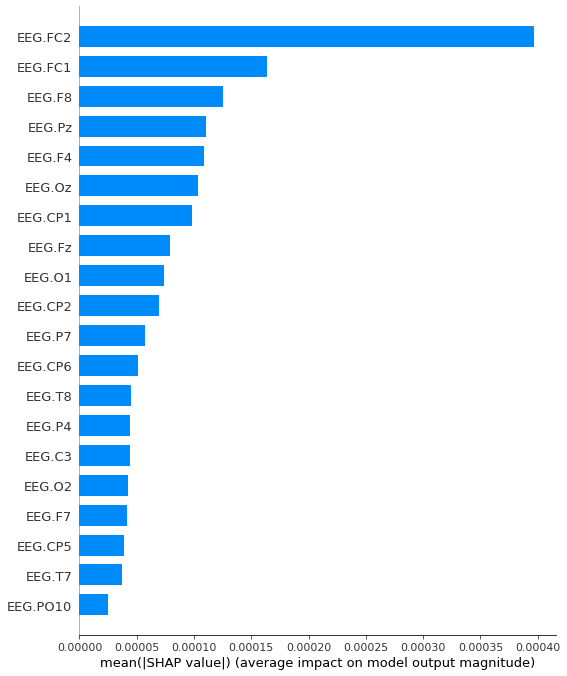

In [14]:
shap.summary_plot(shap_values[2][:, 0, :], cyj_cnn_eeg_input[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# CYY noise-base model

In [15]:
path_list = ['./{}/base/{}.csv', './{}/noise/{}.csv']

In [16]:
cyy_eeg_input_con, output_con = generation_cnn_con_data(path_list, 'cyy', task, device)

10
20
1back
3back
10
20
1back
3back


In [17]:
print(cyy_eeg_input_con.size())
print(output_con.size())

torch.Size([2048, 32, 120])
torch.Size([2048])


In [18]:
dataset_con = MakeDataset(cyy_eeg_input_con, output_con)
train_dataset_con, test_dataset_con = random_split(dataset_con, [1536,512])
trainloader_con = DataLoader(train_dataset_con, 
                         batch_size=256, 
                         shuffle=True)

testloader_con = DataLoader(test_dataset_con,
                        batch_size = 256,
                        shuffle=True)


In [19]:
model_con = CNNEEG_32(32)
his = train_CNNEEG(model_con, trainloader_con, 1000, 0.0001, device= device)

Epoch 1 / 1000: Loss = 1.123
Epoch 2 / 1000: Loss = 1.103


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 3 / 1000: Loss = 1.084
Epoch 4 / 1000: Loss = 1.065
Epoch 5 / 1000: Loss = 1.047
Epoch 6 / 1000: Loss = 1.029
Epoch 7 / 1000: Loss = 1.014
Epoch 8 / 1000: Loss = 1.003
Epoch 9 / 1000: Loss = 0.994
Epoch 10 / 1000: Loss = 0.987
Epoch 11 / 1000: Loss = 0.981
Epoch 12 / 1000: Loss = 0.977
Epoch 13 / 1000: Loss = 0.973
Epoch 14 / 1000: Loss = 0.970
Epoch 15 / 1000: Loss = 0.967
Epoch 16 / 1000: Loss = 0.965
Epoch 17 / 1000: Loss = 0.963
Epoch 18 / 1000: Loss = 0.961
Epoch 19 / 1000: Loss = 0.959
Epoch 20 / 1000: Loss = 0.957
Epoch 21 / 1000: Loss = 0.955
Epoch 22 / 1000: Loss = 0.954
Epoch 23 / 1000: Loss = 0.952
Epoch 24 / 1000: Loss = 0.951
Epoch 25 / 1000: Loss = 0.949
Epoch 26 / 1000: Loss = 0.948
Epoch 27 / 1000: Loss = 0.946
Epoch 28 / 1000: Loss = 0.945
Epoch 29 / 1000: Loss = 0.943
Epoch 30 / 1000: Loss = 0.942
Epoch 31 / 1000: Loss = 0.940
Epoch 32 / 1000: Loss = 0.939
Epoch 33 / 1000: Loss = 0.938
Epoch 34 / 1000: Loss = 0.936
Epoch 35 / 1000: Loss = 0.935
Epoch 36 / 1000: 

In [20]:
train_pred_list_con, train_target_list_con, test_pred_list_con, test_target_list_con = evaluation_eegcnn(model_con, trainloader_con, testloader_con, 256, device)

Train dataset loss : 0.7981401085853577
Train dataset acc :75.1953125%
Test dataset loss : 0.8945668637752533
Test dataset acc :65.234375%


In [21]:
import shap

In [22]:
explainer_shap_con = shap.DeepExplainer(model_con, cyy_eeg_input_con.float()[:100])
shap_values_con = explainer_shap_con.shap_values(cyy_eeg_input_con.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [23]:
for i in range(len(shap_values_con)):
    shap_values_con[i] = shap_values_con[i].reshape(100, 120, 32)

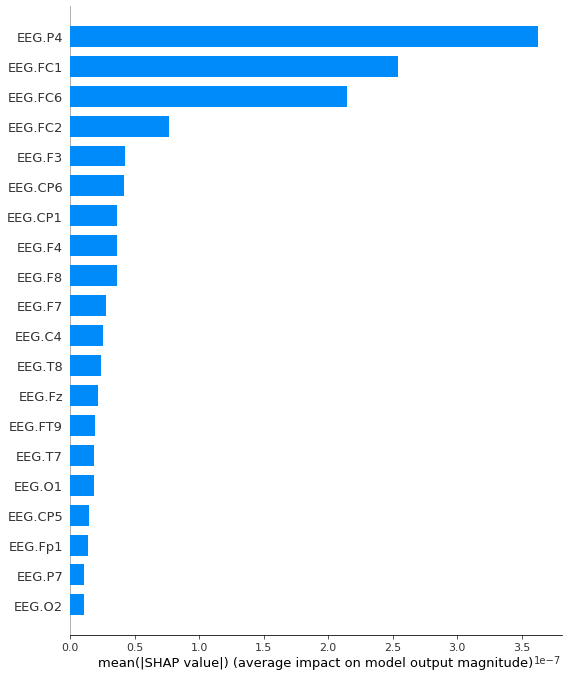

In [24]:
shap.summary_plot(shap_values_con[0][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

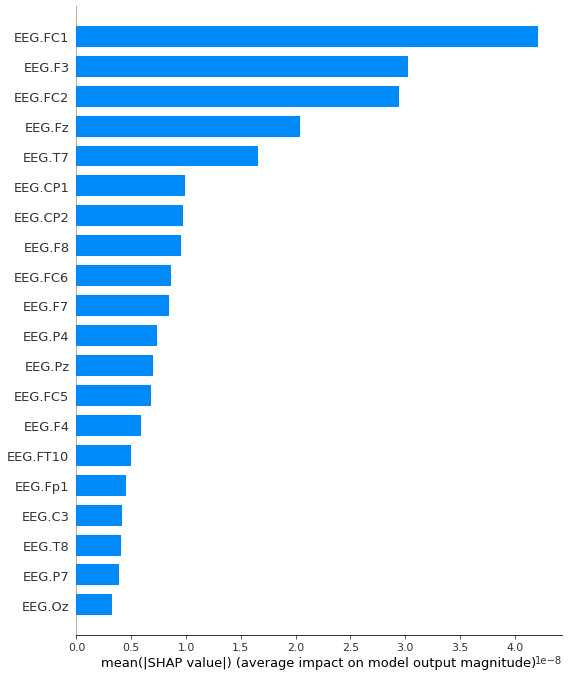

In [25]:
shap.summary_plot(shap_values_con[1][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

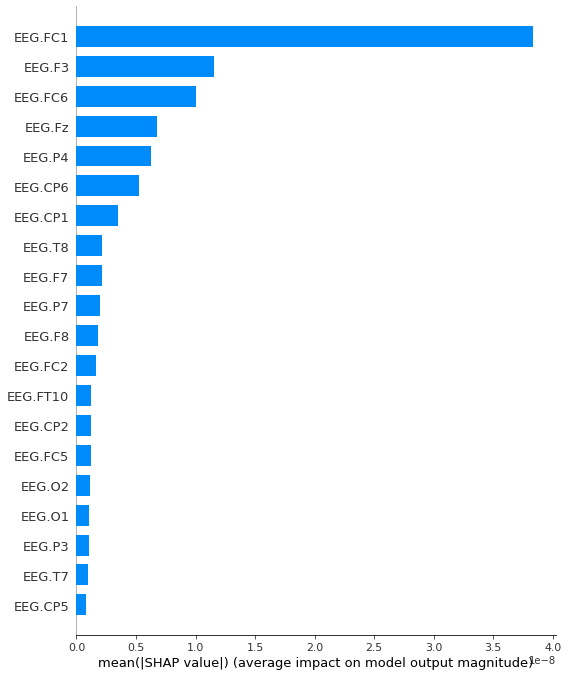

In [26]:
shap.summary_plot(shap_values_con[2][:, 0, :], cyy_eeg_input_con[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

# CYY noise CNN

In [27]:
eeg_input_noise, output_noise =  generation_cnn_noisedata('./{}/noise/{}.csv', 'cyy', task, device)

10
20
1back
3back


In [28]:
print(eeg_input_noise.size())
print(output_noise.size())

dataset_noise = MakeDataset(eeg_input_noise, output_noise)
train_dataset_noise, test_dataset_noise = random_split(dataset_noise, [1536,512])
trainloader_noise = DataLoader(train_dataset_noise, 
                         batch_size=256, 
                         shuffle=True)

testloader_noise = DataLoader(test_dataset_noise,
                        batch_size = 256,
                        shuffle=True)


torch.Size([2048, 32, 120])
torch.Size([2048])


In [29]:
model_noise = CNNEEG_32(32)
his = train_CNNEEG(model_noise, trainloader_noise, 1000, 0.0001, device= device)

Epoch 1 / 1000: Loss = 1.057


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 2 / 1000: Loss = 1.037
Epoch 3 / 1000: Loss = 1.021
Epoch 4 / 1000: Loss = 1.013
Epoch 5 / 1000: Loss = 1.006
Epoch 6 / 1000: Loss = 1.000
Epoch 7 / 1000: Loss = 0.994
Epoch 8 / 1000: Loss = 0.988
Epoch 9 / 1000: Loss = 0.982
Epoch 10 / 1000: Loss = 0.977
Epoch 11 / 1000: Loss = 0.972
Epoch 12 / 1000: Loss = 0.968
Epoch 13 / 1000: Loss = 0.964
Epoch 14 / 1000: Loss = 0.960
Epoch 15 / 1000: Loss = 0.956
Epoch 16 / 1000: Loss = 0.953
Epoch 17 / 1000: Loss = 0.950
Epoch 18 / 1000: Loss = 0.948
Epoch 19 / 1000: Loss = 0.945
Epoch 20 / 1000: Loss = 0.943
Epoch 21 / 1000: Loss = 0.941
Epoch 22 / 1000: Loss = 0.939
Epoch 23 / 1000: Loss = 0.937
Epoch 24 / 1000: Loss = 0.935
Epoch 25 / 1000: Loss = 0.934
Epoch 26 / 1000: Loss = 0.932
Epoch 27 / 1000: Loss = 0.930
Epoch 28 / 1000: Loss = 0.929
Epoch 29 / 1000: Loss = 0.928
Epoch 30 / 1000: Loss = 0.927
Epoch 31 / 1000: Loss = 0.925
Epoch 32 / 1000: Loss = 0.924
Epoch 33 / 1000: Loss = 0.922
Epoch 34 / 1000: Loss = 0.921
Epoch 35 / 1000: L

In [30]:
trainnoise_pred_list, trainnoise_target_list, testnoise_pred_list, testnoise_target_list = evaluation_eegcnn(model_noise,
                                                                                                              trainloader_noise, testloader_noise, 256, device)

Train dataset loss : 0.7587534189224243
Train dataset acc :79.1015625%
Test dataset loss : 0.8609700202941895
Test dataset acc :68.359375%


In [31]:
torch.argmax(model_noise(eeg_input_noise[:256].float()), dim = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1], device='cuda:0')

In [32]:
explainer_shap_noise = shap.DeepExplainer(model_noise, eeg_input_noise.float()[:100])
shap_values_noise = explainer_shap_noise.shap_values(eeg_input_noise.float()[:100])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [33]:
for i in range(len(shap_values_noise)):
    shap_values_noise[i] = shap_values_noise[i].reshape(100, 120, 32)

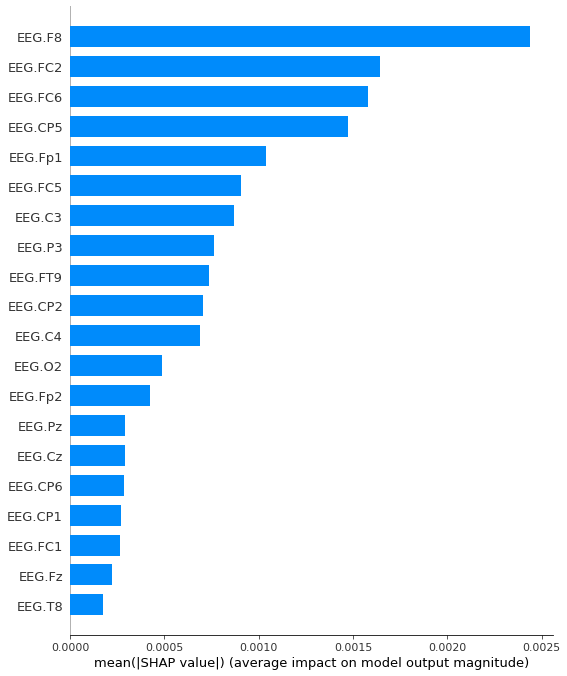

In [34]:
shap.summary_plot(shap_values_noise[0][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

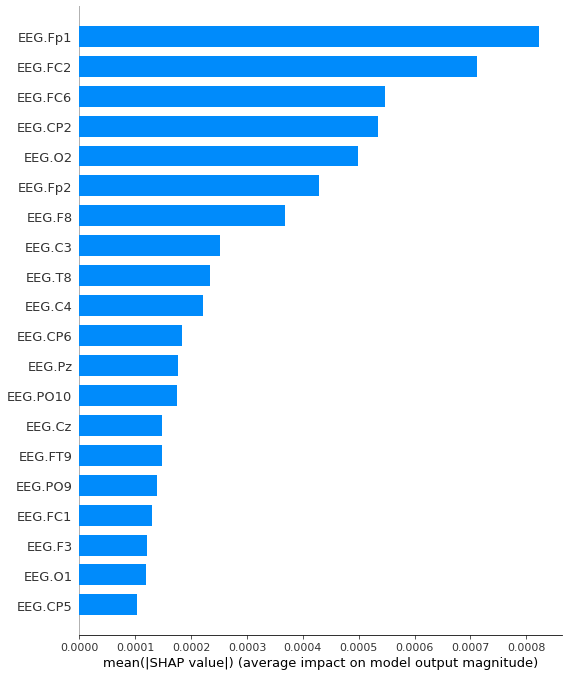

In [35]:
shap.summary_plot(shap_values_noise[1][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')

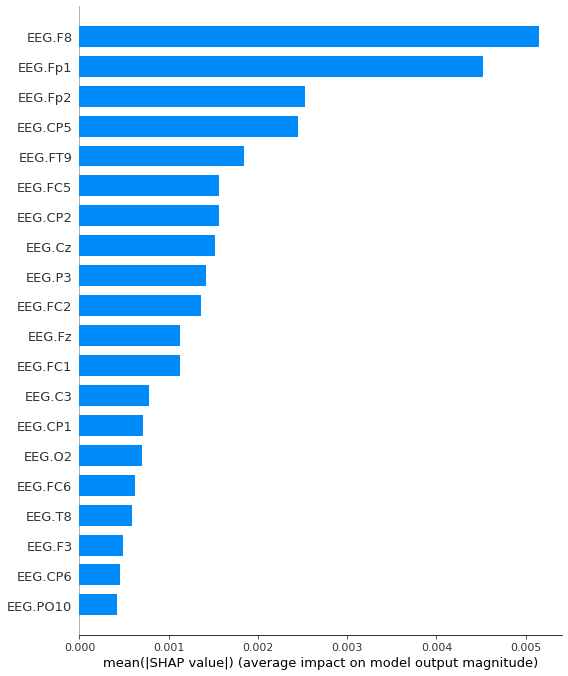

In [36]:
shap.summary_plot(shap_values_noise[2][:, 0, :], eeg_input_noise[:100].detach().cpu().numpy().reshape(100,120,32)[:, 0, :], 
                  feature_names=eeg_col, plot_type='bar')